   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
5      1  FreeMsg Hey there darling it's been 3 week's n...
6      0  Even my brother is not like to speak with me. ...
7      0  As per your request 'Melle Melle (Oru Minnamin...
8      1  WINNER!! As a valued network customer you have...
9      1  Had your mobile 11 months or more? U R entitle...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB
None
label
0    0.865937
1    0.134063


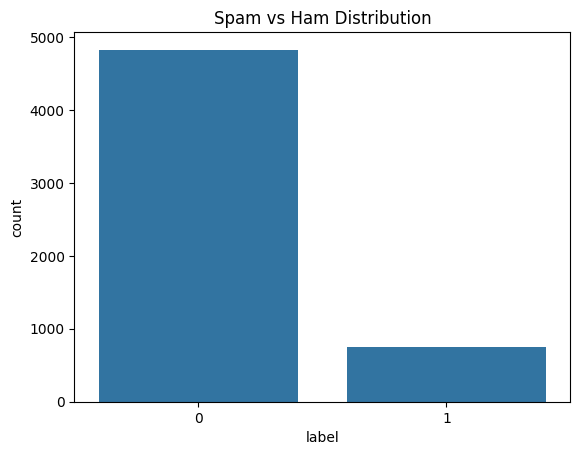

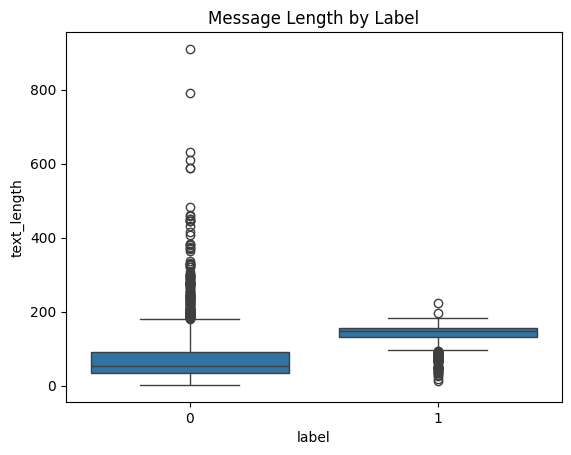

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Optional: pip install seaborn for better visuals

# Load with encoding fix
try:
    df = pd.read_csv('../data/spam.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv('../data/spam.csv', encoding='latin-1')

# Clean columns (dataset has extras sometimes)
df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
df['label'] = df['label'].map({'ham': 0, 'spam': 1})  # Binary: 0=ham, 1=spam

# Stats
print(df.head(10))  # View samples
print(df.info())    # Check types/nulls
print(df['label'].value_counts(normalize=True))  # ~87% ham, 13% spam
print(df['text'].apply(len).describe())  # Length stats

# Visualize imbalance and lengths
sns.countplot(x='label', data=df)
plt.title('Spam vs Ham Distribution')
plt.show()

df['text_length'] = df['text'].apply(len)
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Message Length by Label')
plt.show()

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

# Download NLTK data (run once, comment out after)
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = text.split()  # Tokenize into words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 1]  # Lemmatize, remove stopwords and short words
    return ' '.join(words)

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)

# Verify the result
print(df[['text', 'clean_text']].head(10))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   
5  FreeMsg Hey there darling it's been 3 week's n...   
6  Even my brother is not like to speak with me. ...   
7  As per your request 'Melle Melle (Oru Minnamin...   
8  WINNER!! As a valued network customer you have...   
9  Had your mobile 11 months or more? U R entitle...   

                                          clean_text  
0  go jurong point crazy available bugis great wo...  
1                              ok lar joking wif oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                      dun say early hor already say  
4           nah dont think go usf life around though  
5  freemsg hey darling week word back id like fun... 

In [4]:
test_text = "Hello! Win free prize now!!"
print(preprocess_text(test_text))

hello win free prize


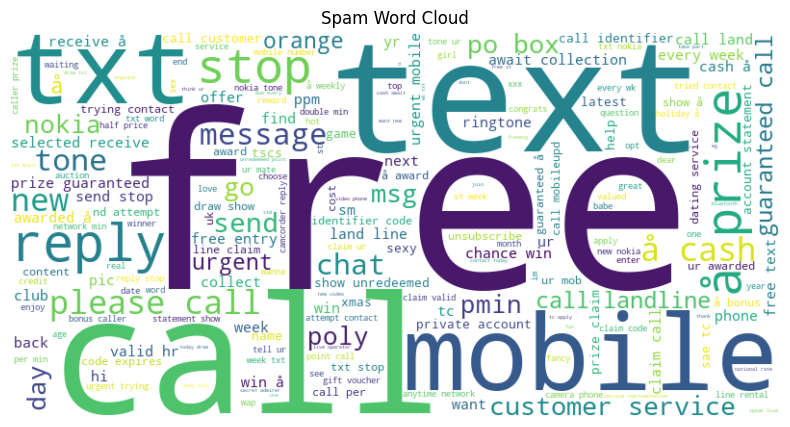

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all spam messages (where label == 1)
spam_words = ' '.join(df[df['label'] == 1]['clean_text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)

# Display
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Spam Word Cloud')
plt.axis('off')  # Hide axes
plt.show()

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # Include bigrams for better spam detection
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

# Stratified split to handle imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (4457, 5000), Test shape: (1115, 5000)


Accuracy: 0.9740
Precision: 0.8947
Recall: 0.9128
F1-Score: 0.9037
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       966
           1       0.89      0.91      0.90       149

    accuracy                           0.97      1115
   macro avg       0.94      0.95      0.94      1115
weighted avg       0.97      0.97      0.97      1115



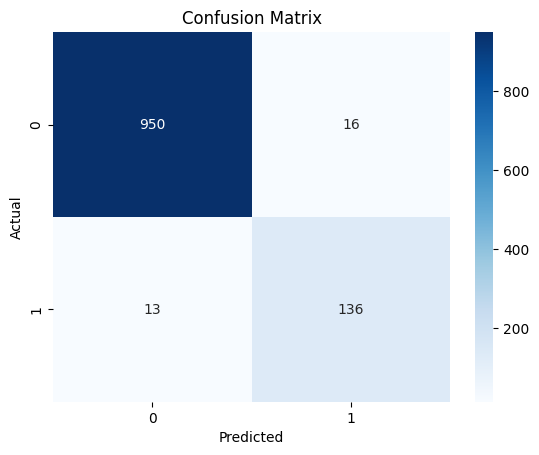

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

model = LogisticRegression(class_weight='balanced', max_iter=200)  # Increase iter if convergence warning
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
import joblib
joblib.dump(model, '../models/spam_classifier.pkl')
joblib.dump(vectorizer, '../models/vectorizer.pkl')
print("Model and vectorizer saved!")

Model and vectorizer saved!
